<a href="https://colab.research.google.com/github/maxrinal/nlp-disaster/blob/master/Gomez_101051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! python -m textblob.download_corpora
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import string,re
import unicodedata
import seaborn as sns
import math
import html
import urllib.parse
import html
test = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv')

#tomo como validos los datos que no contengan nulos
df_test = test
df_test = df_test.dropna()
df_test.sample(n=2)



In [0]:

# Importo el listado de stopwords de english ntlk
# https://www.tutorialspoint.com/python_text_processing/python_remove_stopwords.htm

nltk.download('stopwords')
from nltk.corpus import stopwords

# Obtengo un "list" de las stop_words más comunes del idioma ingles
english_stop_words = stopwords.words('english')

# Agrego a la lista de remover la palabra vacia
english_stop_words.append('')

In [380]:
df_clean = df_test 
df_clean.head(5)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [381]:
#cantidad de localizaciones del set
len(df_clean.location.to_list())

5080

In [382]:
#cantidad de localizaciones distintas
len(set(df_clean.location.to_list()))

3341

#Limpieza del set

In [0]:
#Limpieza del set

# Transformo todos los textos a minusculas
df_clean.location = df_clean.location.str.lower()
df_clean.text = df_clean.text.str.lower()

# Remuevo html entities NUEVO
df_clean.text = df_clean.text.apply( lambda x: html.unescape(  x  ) )

# Hago decode de todos los textos que esten encodeados en formato url NUEVO
df_clean.text = df_clean.text.apply( lambda x: urllib.parse.unquote( str(x) ) )

# Intento remover todos los links que figuren en el texto
df_clean.location = df_clean.location.apply( lambda x:  re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x) ) )
df_clean.text = df_clean.text.apply( lambda x:  re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x) ) )

# Remuevo todos los signos de puntuacion
df_clean.text = df_clean.text.str.translate(str.maketrans('','',string.punctuation))
df_clean.location = df_clean.location.str.translate(str.maketrans('','',string.punctuation))

# Remuevo todos los numeros de la cadena de caracteres
df_clean.location = df_clean.location.str.translate(str.maketrans('','','1234567890'))
df_clean.text = df_clean.text.str.translate(str.maketrans('','','1234567890'))


# Usando TextBlob transformo los plurales a singulares, como me devuelve una lista tengo que volver a armar el string
df_clean.location = df_clean.location.apply( lambda x: " ".join(TextBlob(x).words.singularize()) )
df_clean.text =  df_clean.text.apply( lambda x: " ".join(TextBlob(x).words.singularize()) )

# Separo los textos, borro los stop words y los vuelvo a unir
df_clean.location = df_clean.location.str.split().apply( lambda x: [a for a in x if a not in english_stop_words] ).apply( lambda x: " ".join(x) )
df_clean.text = df_clean.text.str.split().apply( lambda x: [a for a in x if a not in english_stop_words] ).apply( lambda x: " ".join(x) )

In [0]:
#Remuevo caracteres no ascii
df_clean.text = df_clean.text.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('latin-1', 'ignore') )
df_clean.location = df_clean.location.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('latin-1', 'ignore') )

#Frecuencia de palabras en el campo text

In [0]:
#Observo las palabras que predominan en text
words = df_clean.text.to_list()
words = ' '.join(words).split(' ')
words_freq = nltk.FreqDist(words)

In [386]:
#cantidad de palabras distintas
len(list(words_freq))

12177

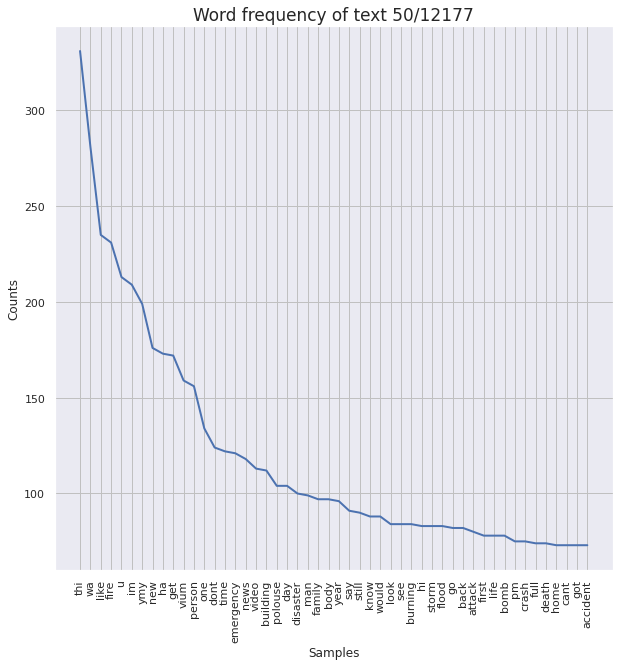

In [387]:
plt.figure(figsize=(10, 10))
plt.title('Word frequency of text 50/12177', fontsize = 17)
words_freq.plot(50, cumulative = False)

In [0]:
#Observo las palabras de clase 1 (target == 1) que predominan
words_clase1 = df_clean[df_clean['target'] == 1].text.to_list()
words_clase1 = ' '.join(words_clase1).split(' ')
words_clase1_freq = nltk.FreqDist(words_clase1)

In [389]:
#cantidad de palabras distintas clase 1
len(list(words_clase1_freq))

6426

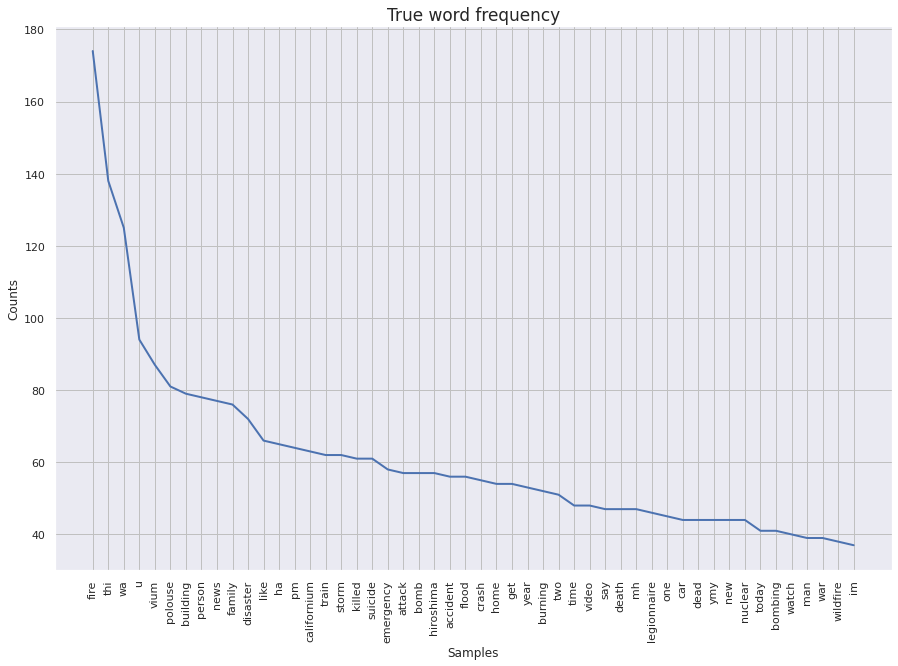

In [390]:
plt.figure(figsize=(15, 10))
plt.title('True word frequency', fontsize = 17)
words_clase1_freq.plot(50, cumulative = False)

In [0]:
#Observo palabras clase 0 (target == 0) que predominan
words_clase0 = df_clean[df_clean['target'] == 0].text.to_list()
words_clase0 = ' '.join(words_clase0).split(' ')
words_clase0_freq = nltk.FreqDist(words_clase0)

In [392]:
#cantidad de palabras distintas clase 0
len(list(words_clase0_freq))

8532

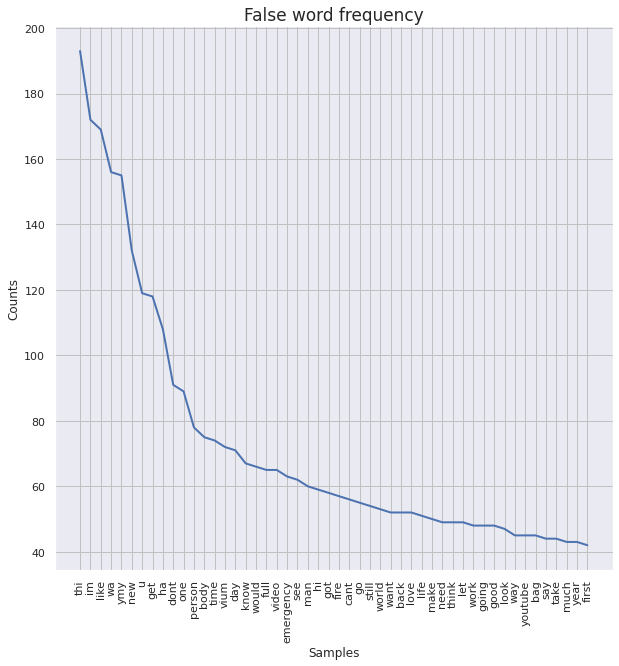

In [393]:
plt.figure(figsize=(10, 10))
plt.title('False word frequency', fontsize = 17)
words_clase0_freq.plot(50, cumulative = False)

Se observa que hay palabras de longitud 1 o 2 las cuales no aportan informacion y posiblemente sean errores. Con el fin de luego poder visualizar las mas representativas por cada localización considero eliminarlas

In [394]:
df_clean.head(2)

,id,keyword,location,text,target
31,48,ablaze,birmingham,bbcmtd wholesale market ablaze,1
32,49,ablaze,est september bristol,alway try bring heavy metal rt,0


In [0]:
def remove_short_word(words):
  new_words = ''
  for w in words.split(' '):
    if(len(w) > 2):
      new_words = new_words + w + ' '
  return new_words

In [0]:
#Elimino las palabras de longitud menor o igual a 2 de la columna text
df_clean.text = df_clean.text.apply(lambda x: remove_short_word(x))

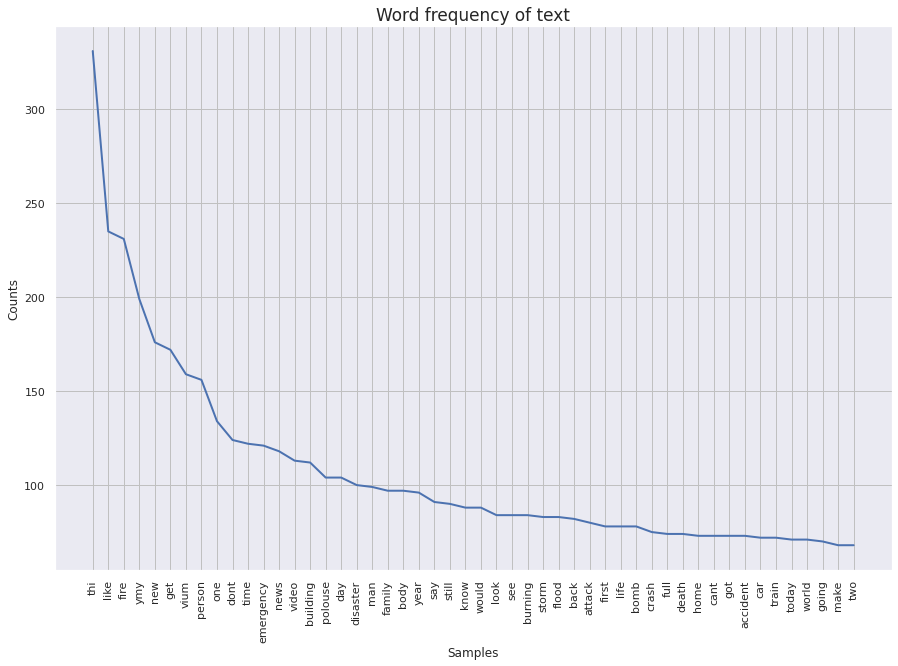

In [397]:
#Observo nuevamente las palabras que predominan en text de ambas clases
words = df_clean.text.to_list()
words = ' '.join(words).split(' ')
words_freq = nltk.FreqDist(words)
words_freq.pop('')
plt.figure(figsize=(15, 10))
plt.title('Word frequency of text', fontsize = 17)
words_freq.plot(50, cumulative = False)

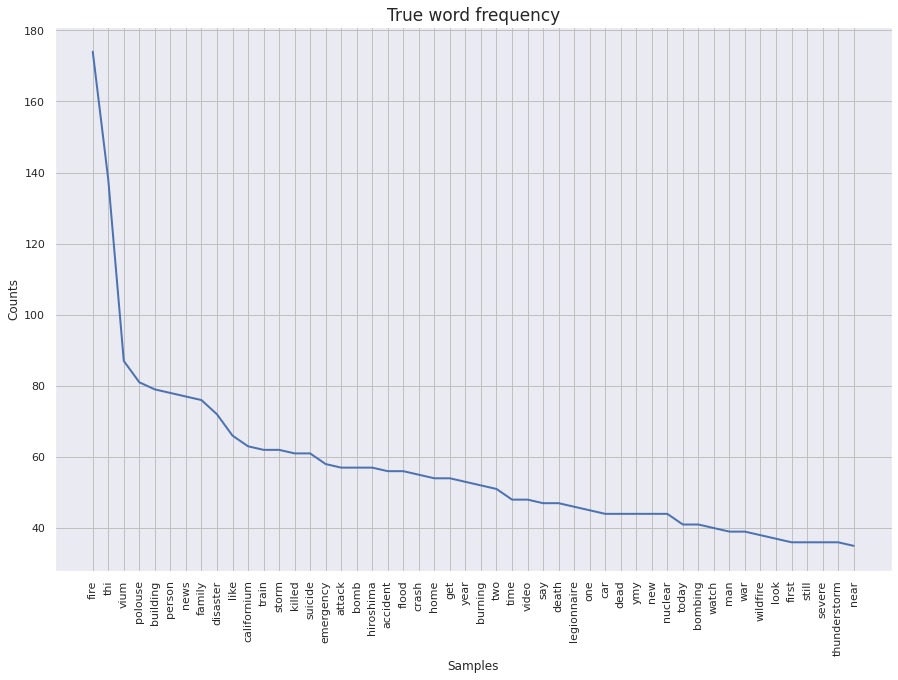

In [398]:
#Observo nuevamente la distribucion de frecuencias de las palabras clase 1
words_clase1 = df_clean[df_clean['target'] == 1].text.to_list()
words_clase1 = ' '.join(words_clase1).split(' ')
words_clase1_freq = nltk.FreqDist(words_clase1)
words_clase1_freq.pop('')
plt.figure(figsize=(15, 10))
plt.title('True word frequency',fontsize = 17)
words_clase1_freq.plot(50, cumulative = False)

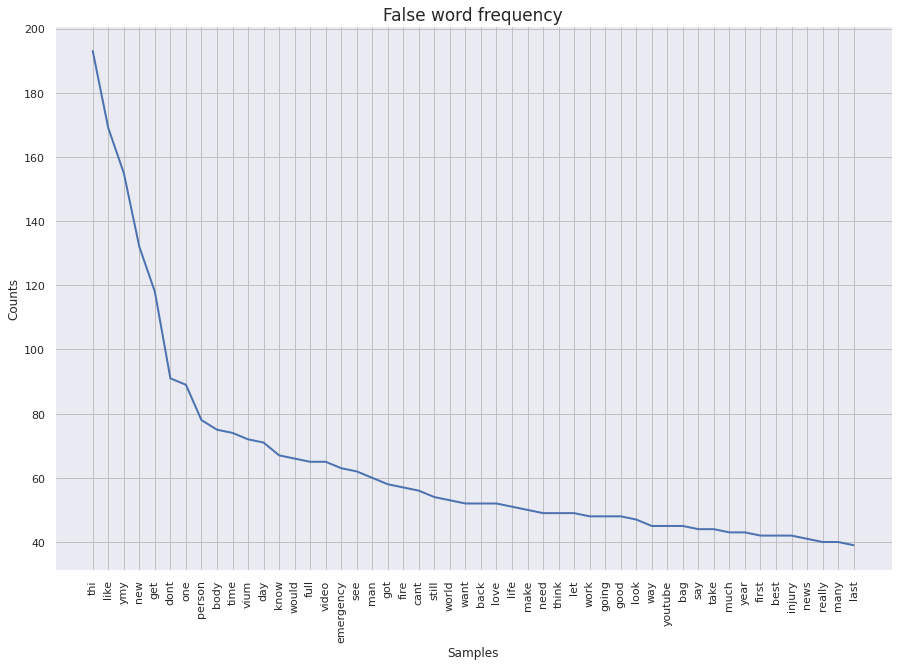

In [399]:
words_clase0 = df_clean[df_clean['target'] == 0].text.to_list()
words_clase0 = ' '.join(words_clase0).split(' ')
words_clase0_freq = nltk.FreqDist(words_clase0)
#Elimino los vacios posibles debido a texts sin valor
words_clase0_freq.pop('')
plt.figure(figsize=(15, 10))
plt.title('False word frequency',fontsize = 17)
words_clase0_freq.plot(50, cumulative = False)

#Frecuencia de palabras por localización

In [400]:
#Realizo el mismo analisis con las localizaciones
location = df_clean.location.to_list()
location_freq = nltk.FreqDist(location)
len(list(location_freq))

2925

Se puede observar en gran parte, referencias a un mismo lugar de distintas formas. Por lo que conviene unir las mas comunes/representativas en una misma y eliminar palabras de 2 letras, que generan por ejemplo que: 
(washington dc != washington)

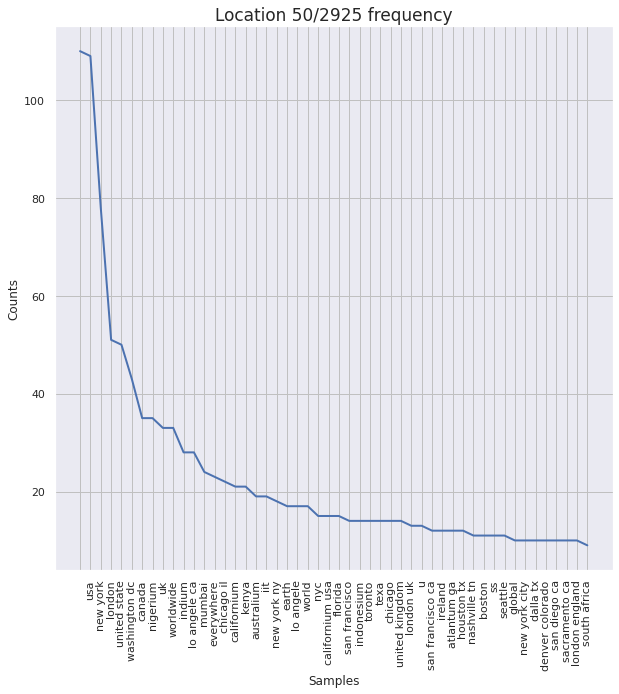

In [401]:
plt.figure(figsize=(10, 10))
plt.title('Location 50/2925 frequency',fontsize = 17)
location_freq.plot(50, cumulative = False)

In [0]:
#Elimino espacios innecesarios, agrupo distintas comunes referencias de una misma locacion en una sola y elimino palabras de longitud menor o igual a 2
df_clean.location = df_clean.location.apply(lambda x: 'united states' if (x == 'us' or x == 'usa' or x == 'united state')  else x)
df_clean.location = df_clean.location.apply(lambda x: 'united kingdom' if (x == 'uk')  else x)
df_clean.location = df_clean.location.apply(lambda x: 'new york' if (x == 'ny' or x == 'nyc' or x == 'new york city')  else x)
df_clean.location = df_clean.location.apply(lambda x: 'canada' if (x == 'ca')  else x)
df_clean.location = df_clean.location.apply(lambda x: 'new jersey' if (x == 'nj')  else x)
df_clean.location = df_clean.location.apply(lambda x: remove_short_word(x))
df_clean.location = df_clean.location.apply(lambda x: x.strip())
df_clean.location = df_clean.location.apply(lambda x: 'angeles' if (x == 'angele')  else x)
df_clean = df_clean[df_clean['location'] != '']

In [403]:
#Reitero el analisis de localizaciones
location = df_clean.location.to_list()
location_freq = nltk.FreqDist(location)
len(list(location_freq))

2761

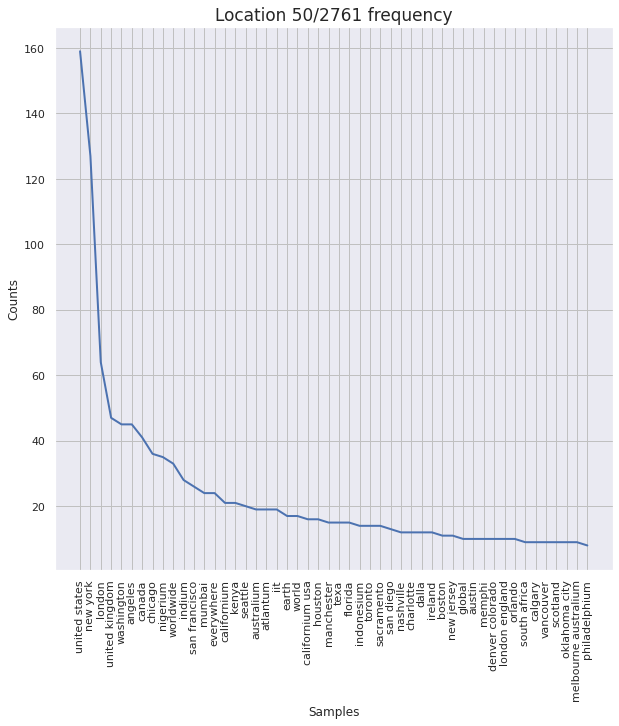

In [404]:
plt.figure(figsize=(10, 10))
plt.title('Location 50/2761 frequency',fontsize = 17)
location_freq.plot(50, cumulative = False)

Se puede observar que la mayor parte de las referencias se logran reunir en una localizacion en comun, notandose la predominancia de ciertas localizaciones y dada la rapida caída de la curva, considero despreciar las demas.
En proximos trabajos se tratara de reunir todas en la misma referencia a una localizacion

In [0]:
#tomo el top de palabras de cada clase, dado que no puedo visualizar todas
words_clase1 =  dict(words_clase1_freq)
words_clase0 = dict(words_clase0_freq)
words_clase1 = [(k,v) for k,v in words_clase1.items()]
words_clase0 = [(k,v) for k,v in words_clase0.items()]
words_clase1 = sorted(words_clase1, key = lambda x: x[1], reverse = True)
words_clase0 = sorted(words_clase0, key = lambda x: x[1], reverse = True)

top_clase1 = []
top_clase0 = []
for i in range(0,35):
  top_clase0.append(words_clase0[i][0]) 
  top_clase1.append(words_clase1[i][0]) 

In [0]:
#Agrupo por localizacion y combino sus textos
words_vs_loc = df_clean.drop(['target','keyword','id'], axis = 1)
words_vs_loc = words_vs_loc.groupby('location').text.apply(lambda x: ' '.join(x))
words_vs_loc = words_vs_loc.to_frame()
words_vs_loc_1 = words_vs_loc.copy()
words_vs_loc_0 = words_vs_loc.copy()

In [0]:
#cuento las palabras del top de clase respectivo de cada localizacion
for w in top_clase1: 
  words_vs_loc_1[w] = words_vs_loc_1.text.apply(lambda x: str(x).count(w))

In [0]:
for w in top_clase0: 
  words_vs_loc_0[w] = words_vs_loc_0.text.apply(lambda x: str(x).count(w))

In [0]:
#Cuento la cantidad de cada palabra del top que proviene de cada locacion para poder filtrar y visualizar los mas representativos
words_vs_loc_1['total_words'] = words_vs_loc_1.sum(axis = 1)
words_vs_loc_0['total_words'] = words_vs_loc_0.sum(axis = 1)

In [0]:
#heatmaps
hmap1 = words_vs_loc_1[words_vs_loc_1['total_words'] > 20]
hmap2 = words_vs_loc_0[words_vs_loc_0['total_words'] > 20]
hmap1 = hmap1.drop(['text','total_words'], axis = 1)
hmap2 = hmap2.drop(['text','total_words'], axis = 1)

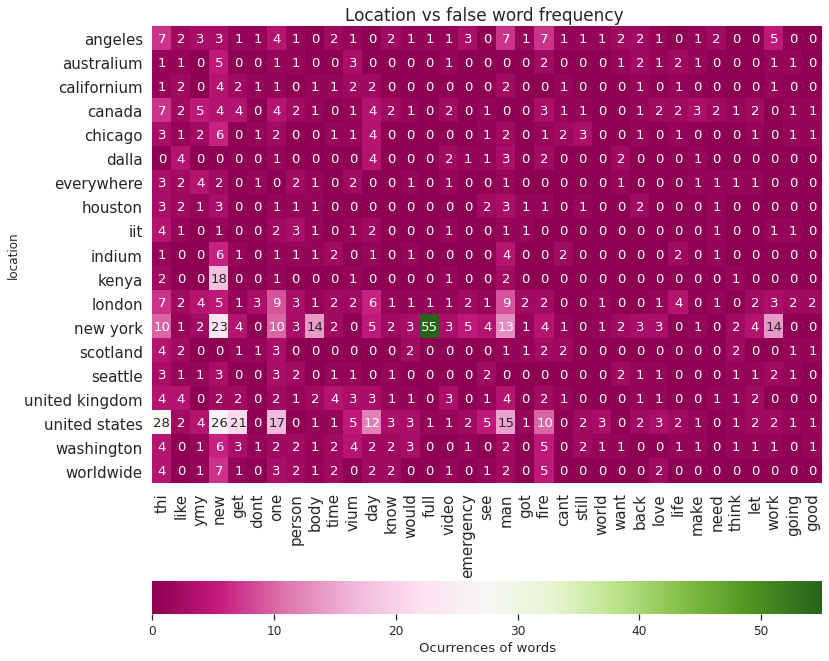

In [411]:
#heatmap words clase 0
plt.figure(figsize=(12, 12))
plt.title('Location vs false word frequency ',fontsize = 17)
sns.set(font_scale = 1.1)
s2 = sns.heatmap(hmap2, cmap="PiYG",annot = True, cbar_kws={'orientation': 'horizontal','label': 'Ocurrences of words'})
s2.tick_params(labelsize = 15)

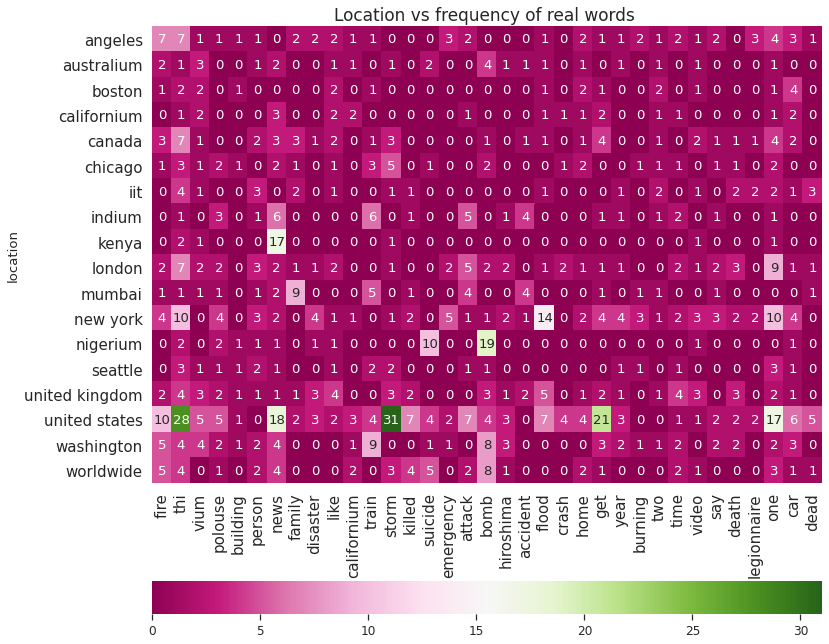

In [412]:
#heatmap words clase 1
plt.figure(figsize=(12, 12))
plt.title('Location vs frequency of real words ',fontsize = 17)
s1 = sns.heatmap(hmap1, cmap="PiYG", annot = True, cbar_kws={"orientation": "horizontal"})
s1.tick_params(labelsize = 15)

In [0]:
#dado que se repiten palabras que no aportan información en ambas clases muy frecuentemente paso a eliminarlas si estan en ambos grupos (clase 0 y clase 1)
top_word_1_unique = []
for w in top_clase1:
  if(w not in top_clase0):
    top_word_1_unique.append(w)

In [0]:
words_vs_loc_1_unique = words_vs_loc

In [0]:
for w in top_word_1_unique: 
  words_vs_loc_1_unique[w] = words_vs_loc.text.apply(lambda x: str(x).count(w))

In [0]:
words_vs_loc_1_unique['total_words'] = words_vs_loc_1_unique.sum(axis = 1)
hmap3 = words_vs_loc_1_unique[words_vs_loc_1_unique['total_words'] > 20]
hmap3 = hmap3.drop(['text','total_words'], axis = 1)

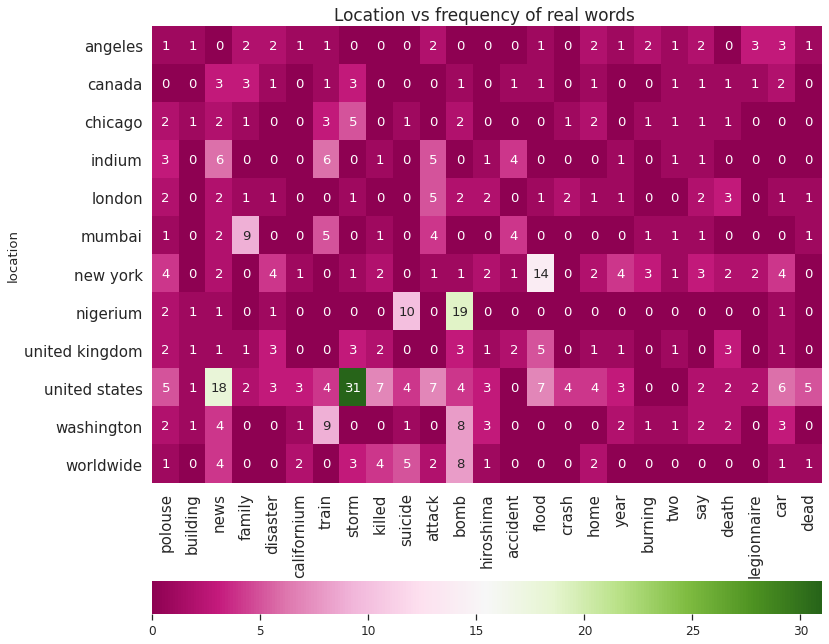

In [417]:
#heatmap words unicas clase 1 
plt.figure(figsize=(12, 12))
plt.title('Location vs frequency of real words ',fontsize = 17)
s1 = sns.heatmap(hmap3, cmap="PiYG", annot = True, cbar_kws={"orientation": "horizontal"})
s1.tick_params(labelsize = 15)


#Keywords frecuentes por localización

In [0]:
#Obtengo todas las keywords sin repeticion
keywords = [(k,v) for k,v in dict(df_clean.keyword.value_counts()).items()]
keywords = sorted(keywords, key = lambda x: x[1], reverse = True)
top_keywords = []
for i in range(0,35): top_keywords.append(keywords[i][0])

In [0]:
def count_keywords(x,keywords):
  counts = []
  for k in keywords:
    counts.append(x.count(k))
  return counts

In [0]:
keywords_vs_loc = df_clean.copy()
# Hago decode de todos las keywords que esten encodeados en formato url NUEVO
keywords_vs_loc.keyword = keywords_vs_loc.keyword.apply( lambda x: urllib.parse.unquote( str(x) ) )
keywords_vs_loc.keyword = keywords_vs_loc.keyword.apply( lambda x:  re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x) ) )

In [0]:
#Junto todas las keywords en cadena para cada localizacion
keywords_vs_loc = keywords_vs_loc.groupby('location').keyword.apply(lambda x: ' '.join(x)).to_frame()

In [0]:
#cuento cuantas keywords estan asociadas a cada localizacion
keywords_vs_loc = keywords_vs_loc.keyword.apply(lambda x: count_keywords(str(x),top_keywords)).to_frame()

In [0]:
#separo en columnas por cada keyword y paso a formato numero para el heatmap
keywords_vs_loc.keyword = keywords_vs_loc.keyword.apply(lambda x: ' '.join(str(i) for i in x))
keywords_vs_loc.head(2)
keywords_vs_loc = pd.DataFrame(keywords_vs_loc.keyword.str.split(' ', len(top_keywords)).to_list(), columns = top_keywords, index = keywords_vs_loc.index)
keywords_vs_loc = keywords_vs_loc.apply(pd.to_numeric)

In [0]:
#filtro para poder visualizar las mas representativas
keywords_vs_loc['total_keywords'] = keywords_vs_loc.sum(axis = 1)
hmap3 = keywords_vs_loc[keywords_vs_loc['total_keywords'] > 5].drop('total_keywords', axis = 1)

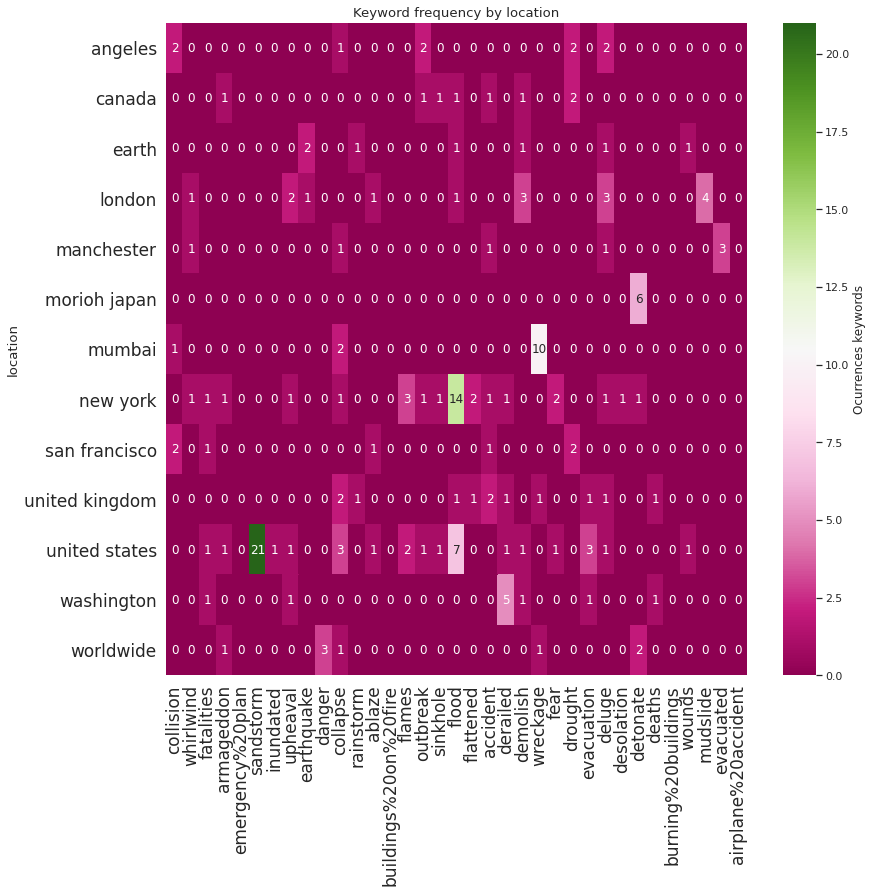

In [425]:
plt.figure(figsize=(13, 12))
plt.title('Keyword frequency by location')
sns.set(font_scale = 1)
s3 = sns.heatmap(hmap3, cmap="PiYG", annot = True,  cbar_kws={'orientation': 'vertical','label': 'Ocurrences keywords'})
s3.tick_params(labelsize = 17)

#Relación del target con la localización

In [426]:
#busco ver la relacion entre target y localización
targetby_loc = df_clean.groupby('location').agg({'target':['sum','count']}).reset_index()
targetby_loc.head(5)

location target      
                            sum count
0                    aaa      1     1
1                   aaaa      0     1
2        aalo mina citya      0     1
3              aamidwest      0     1
4  aarhu central jutland      0     1

In [0]:
targetby_loc = targetby_loc.droplevel(1,axis = 1)

In [0]:
targetby_loc.columns = ['location','target_1','count']

In [0]:
targetby_loc['target_0'] = targetby_loc['count'] - targetby_loc['target_1']

In [0]:
#dada la gran diferencia en ocurrencias de cada localización calculo y visualizo la media de target 1 para observar
#si existe una relación entre cantidad de ocurrencia vs target
targetby_loc['mean_target_1'] = (targetby_loc['target_1']/targetby_loc['count'])

In [431]:
targetby_loc.head(5)

,location,target_1,count,target_0,mean_target_1
0,aaa,1,1,0,1.0
1,aaaa,0,1,1,0.0
2,aalo mina citya,0,1,1,0.0
3,aamidwest,0,1,1,0.0
4,aarhu central jutland,0,1,1,0.0


In [432]:
filtered = targetby_loc[targetby_loc['count']>15]
filtered = filtered.sort_values('count', ascending = False)
filtered.head(5)

,location,target_1,count,target_0,mean_target_1
2482,united states,97,159,62,0.610063
1658,new york,37,127,90,0.291339
1359,london,25,64,39,0.390625
2478,united kingdom,23,47,24,0.489362
80,angeles,17,45,28,0.377778


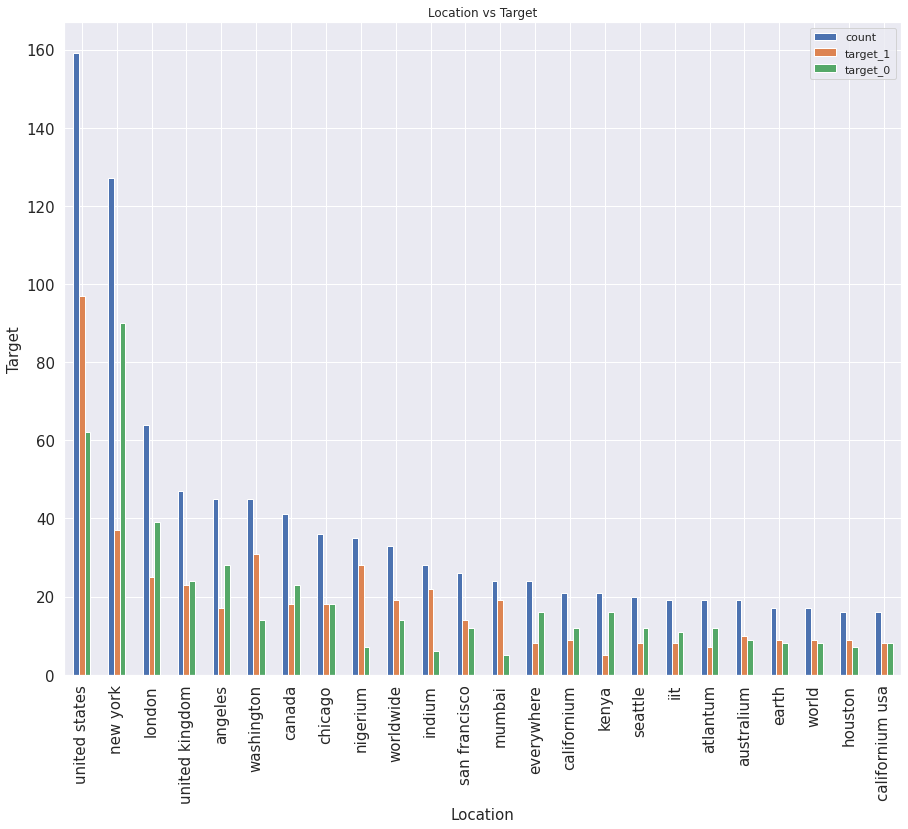

In [433]:
#relacion entre la ubicacion y la cantidad de desastres naturales reales
b1 = filtered.plot.bar(x = 'location', y = ['count','target_1','target_0'], figsize=(15,12), title = 'Location vs Target')
b1.set_xlabel('Location', fontsize = 15)
b1.set_ylabel('Target', fontsize = 15)
b1.tick_params(labelsize = 15)

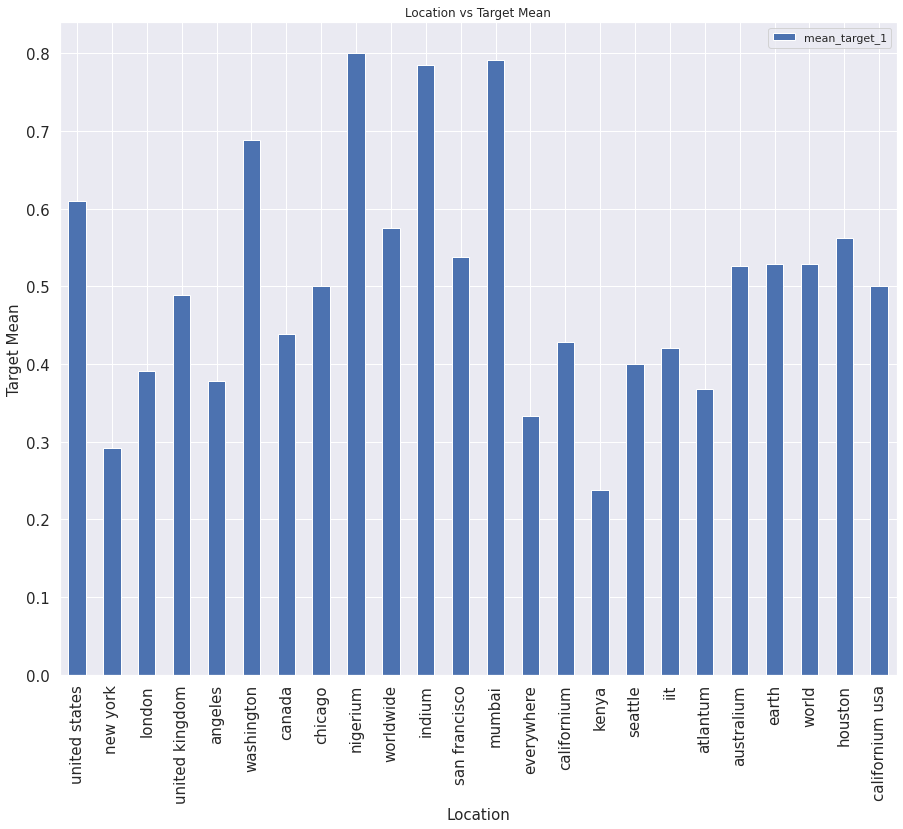

In [434]:
#relacion entre la ubicacion y la cantidad de desastres naturales reales
b2 = filtered.plot.bar(x = 'location', y = ['mean_target_1'], figsize=(15,12), title = 'Location vs Target Mean')
b2.set_xlabel('Location', fontsize = 15)
b2.set_ylabel('Target Mean', fontsize = 15)
b2.tick_params(labelsize = 15)

#Relación localización vs largo del tweet


In [0]:
length_text_byloc = df_clean

def length(x): return len(x)

length_text_byloc['length'] = length_text_byloc['text'].transform(length)

In [0]:
length_text_byloc = length_text_byloc.groupby('location').agg({'length':['sum','count']})

In [437]:
length_text_byloc = length_text_byloc.reset_index()
length_text_byloc.head(5)

location length      
                            sum count
0                    aaa     72     1
1                   aaaa     31     1
2        aalo mina citya     84     1
3              aamidwest     43     1
4  aarhu central jutland     70     1

In [0]:
length_text_byloc = length_text_byloc.droplevel(0, axis = 1)
length_text_byloc.columns = ['location', 'length','count_by_loc']
length_text_byloc['mean'] = length_text_byloc['length']/length_text_byloc['count_by_loc']

In [439]:
length_text_byloc[length_text_byloc['location']=='united states']

,location,length,count_by_loc,mean
2482,united states,10242,159,64.415094


Text(0.5, 1.0, 'Location vs Avg length of tweets')

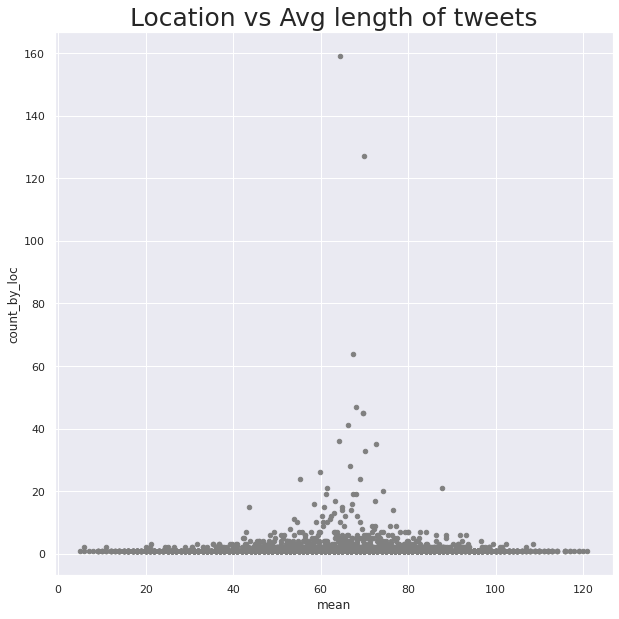

In [440]:

length_text_byloc.plot.scatter(x = 'mean',y = 'count_by_loc', figsize = (10, 10), c = 'gray');
plt.title('Location vs Avg length of tweets', fontsize = 25)